In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install qiskit

     |████████████████████████████████| 8.5MB 15.1MB/s 
     |████████████████████████████████| 17.6MB 217kB/s 
     |████████████████████████████████| 204kB 56.2MB/s 
     |████████████████████████████████| 204kB 60.5MB/s 
     |████████████████████████████████| 2.1MB 49.0MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 1.3MB 36.7MB/s 
     |████████████████████████████████| 5.9MB 40.7MB/s 
     |████████████████████████████████| 194kB 49.5MB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
     |████████████████████████████████| 614kB 48.8MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 2.6MB 45.6MB/s 
     |████████████████████████████████| 5.5MB 40.6MB/s 
  Created wheel for qiskit: filename=qiskit-0.23.2-cp36-none-any.whl size=2876 sha256=5f9337826fa7ae27e1f3d9345f9d906350e46b74b362eedbcbc895ab9003a642
  Stored in directory: /root/.cache/pip/wheels/c2/62/3e/d5aeec3b19ba

In [2]:
import qiskit

print(qiskit.__version__)
print(qiskit.__qiskit_version__)

0.16.1
{'qiskit-terra': '0.16.1', 'qiskit-aer': '0.7.2', 'qiskit-ignis': '0.5.1', 'qiskit-ibmq-provider': '0.11.1', 'qiskit-aqua': '0.8.1', 'qiskit': None}


In [31]:
import os
import subprocess
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn import preprocessing
import cvxopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split, KFold
from pylab import linspace, scatter, meshgrid, contour, array
from scipy.linalg import norm
import functools
from tqdm.notebook import tqdm  #　for jupyter notebook
# from tqdm import tqdm  # for else


from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.ml.datasets import ad_hoc_data, breast_cancer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.algorithms import SklearnSVM
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import optimize_svm


# prepare mesh for prediction

In [4]:
feature_dim = 2  # number of feature
training_dataset_size = 100
testing_dataset_size = 50

# setup for prediction data generation
size = 50  # coloring 50x50 mesh by labeling, effectively visualize boundary 
# mesh_list = np.array([[2*i/size-1, 2*j/size-1] for i in range(size+1) for j in range(size+1)])*np.pi
mesh_list = np.array([[2*i/size, 2*j/size] for i in range(size+1) for j in range(size+1)])*np.pi

# parameter of quantum computer 
shots = 1024
seed = 10598

In [5]:
# define function to evaluate model performance
def eval_model(pred_label, print_mode=True):
    test_label = ["A"]*testing_dataset_size + ["B"]*testing_dataset_size
    
    accuracy = sum([x == y for x, y in zip(pred_label,test_label)])/len(test_label)
    precision = \
        sum([ x == y for x, y in zip(pred_label,test_label) if x == "A"])/sum([x == "A" for x in pred_label])
    recall = \
        sum([ x == y for x, y in zip(pred_label,test_label) if y == "A"])/sum([y == "A" for y in test_label])
    specificity = \
        sum([ x == y for x, y in zip(pred_label,test_label) if y == "B"])/sum([y == "B" for y in test_label])
    f1 = 2*recall*precision/(recall + precision)
    eval_dict = {"accuracy":accuracy, "precision": precision, "recall": recall, "specificity": specificity, "F1-measure":f1}
    if print_mode:
        print("result: ", pred_label)
        print("truth : ", test_label)
        eval_dict_print = {k:round(v,2) for k,v in eval_dict.items()}
        print(eval_dict_print)
    else:
        return eval_dict
    

# define visualization

In [6]:
def heatmap(pred_list, size=50):
    mat = np.flipud(pred_list.reshape(size+1, size+1, order='F'))
    centers = [0, 2*np.pi, 0, 2*np.pi]
    dx, = np.diff(centers[:2])/(size)
    dy, = -np.diff(centers[2:])/(size) 
    extent = [centers[0]-dx/2, centers[1]+dx/2, centers[2]+dy/2, centers[3]-dy/2]
    cmap = mpl.colors.ListedColormap(['orange', 'cyan'])
    # show heatmap
    plt.imshow(mat, interpolation='nearest', vmin=0, vmax=1, cmap=cmap, extent=extent)


def scatter_data(train_for_pred, test_for_pred, train_result, test_result,
                 yshift=-0.155, print_index=False):
    dataset_dict = {"train": train_for_pred, "test": test_for_pred}
    result_dict = {"train":train_result, "test":test_result}
    marker_dict = {"train": "o", "test": "s"}
    
    for data_type in ["train", "test"]:
        data_num_half = int(len(dataset_dict[data_type])/2) # assuming the number of label A and B is in balance
        for label in ["A", "B"]:  
            if label == "A":
                (plot_data, color) = dataset_dict[data_type][:data_num_half], "red"
            elif label == "B":
                (plot_data, color) = dataset_dict[data_type][data_num_half:], "blue"
            plt.plot(plot_data[:,0], plot_data[:,1], marker_dict[data_type], color=color, markersize=10)
        
        # plot mis-classification as "×"
        for i, pred_label in enumerate(result_dict[data_type]):
            if (i < data_num_half and pred_label != 0)\
              or (i >= data_num_half and pred_label != 1): 
                if print_index:
                    plt.text(dataset_dict[data_type][i][0], dataset_dict[data_type][i][1], str(i), 
                            color="white", size=15, fontweight='bold')
                # ↓ for adjusting, current best practice is auto for x-axis and manual set for y-axis
                plt.text(dataset_dict[data_type][i][0], dataset_dict[data_type][i][1] + yshift, "×", 
                         horizontalalignment='center', color="white", size=15, fontweight='bold')
        # plt.axis('off')
        plt.title("Classification Boundary", size=15)

# functions for Hyper Paramter Tuning

In [7]:
cvxopt.solvers.options['show_progress'] = False

def gaussian_kernel(x, y, sigma):
    return np.exp(-norm(x-y)**2 / (2 * (sigma ** 2)))

# x : prediction data-row, 
# a : Lagrange parameter
# b : intercept of boundary plane
# X : training data
# kernel_func : kernel function to use 
def model_rbf(x, a, t, X, b, kernel_func):
    sum_value = 0.0
    for n in range(len(X)):
        sum_value += a[n] * t[n] * kernel_func(x, X[n])
    return sum_value + b
   
def get_lagrange_param(t, kernel, C, print_mode=True):
    # Calculate Lagrange parameter "a" by Quadratic Programming
    N = len(t)
    K = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            K[i, j] = t[i] * t[j] * kernel[i, j]
    
    P = cvxopt.matrix(K)
    q = cvxopt.matrix(-np.ones(N))
    temp1 = np.diag([-1.0]*N)
    temp2 = np.identity(N)
    G = cvxopt.matrix(np.vstack((temp1, temp2)))
    temp1 = np.zeros(N)
    temp2 = np.ones(N) * C
    h = cvxopt.matrix(np.hstack((temp1, temp2)))
    A = cvxopt.matrix(t, (1,N))
    b = cvxopt.matrix(0.0)

    sol = cvxopt.solvers.qp(P=P, q=q, G=G, h=h, A=A, b=b)
    a = array(sol['x']).reshape(N)

    if print_mode:
        print("Lagrange Param")
        print(a)
    
    # extract support vector index
    S = []
    M = []
    for n in range(len(a)):
        if 0 < a[n]:
            S.append(n)
        if 0 < a[n] < C:
            M.append(n)
    
    # Caclulate intercept b
    sum_value = 0
    for n in M:
        temp = 0
        for m in S:
            temp += a[m] * t[m] * kernel[n, m]
        sum_value += (t[n] - temp)
    b = sum_value / len(M)

    return a, b

def make_df(sampler):
    (data, label_bin), label_map =  split_dataset_to_data_and_labels(sampler)
    df = pd.DataFrame(data,columns = ["x","y"])
    df["label"] = label_bin
    return df

In [8]:
kf = KFold(n_splits=4, shuffle=True, random_state=seed)

# define loss function
def score_rbf(params, train_in):
    df_tr = make_df(train_in)
    print(f'sigma: {params["sigma"]}, lambda2: {params["lambda2"]}')
    iter_list = []
    for tr_idx, va_idx in list(kf.split(df_tr)):
        ks_train = {"A": df_tr.loc[tr_idx].query("label == 0").iloc[:,:2].values, "B": df_tr.loc[tr_idx].query("label == 1").iloc[:,:2].values}
        ks_valid = {"A": df_tr.loc[va_idx].query("label == 0").iloc[:,:2].values, "B": df_tr.loc[va_idx].query("label == 1").iloc[:,:2].values}
        
        # provide hpyer parameter
        sigma =  params["sigma"]
        gamma = 0.5/ params["sigma"]**2
        C = 0.5/(params["lambda2"]*len(df_tr))
        kernel_func = functools.partial(gaussian_kernel,sigma=sigma)

        # splited dataset
        data_tr = df_tr.iloc[tr_idx,:2].values
        label_tr = df_tr.iloc[tr_idx,2].apply(lambda x: 2.0*x - 1).values
        data_va = df_tr.iloc[va_idx,:2].values
        label_va = df_tr.iloc[va_idx,2].apply(int).values

        # use qiskit-svm to get kernel
        result = SklearnSVM(ks_train, ks_valid, None, gamma=gamma).run()

        # obtaine model parameter 
        a, b = get_lagrange_param(t=label_tr, kernel=result['kernel_matrix_training'], C = C, print_mode=False)

        # classify data using obtained parameter
        pred_score = array([model_rbf(row, a, label_tr, data_tr, b, kernel_func) for row in data_va])
        pred_label = (pred_score > 0)*1

        # compare given label and prediction 
        accuracy = sum([label == pred for label, pred in zip(label_va, pred_label)])/len(label_va)
        # print(label_va, pred_label)
        # print("accuracy:  ",accuracy)
        iter_list.append(accuracy)

    print(f"accuracy mean: {np.mean(iter_list)}")
    history_g.append((params, 1-np.mean(iter_list)))
    return  {"loss": 1- np.mean(iter_list), "status": STATUS_OK}


def score_rbf_l2(params, train_in):
    df_tr = make_df(train_in)
    iter_list = []
    print(f'sigma: {params["sigma"]}, lambda2: {params["lambda2"]}')
    for tr_idx, va_idx in list(kf.split(df_tr)):
        ks_train = {"A": df_tr.loc[tr_idx].query("label == 0").iloc[:,:2].values, "B": df_tr.loc[tr_idx].query("label == 1").iloc[:,:2].values}
        ks_valid = {"A": df_tr.loc[va_idx].query("label == 0").iloc[:,:2].values, "B": df_tr.loc[va_idx].query("label == 1").iloc[:,:2].values}
        
        # provide hpyer parameter
        sigma =  params["sigma"]
        gamma = 0.5/ params["sigma"]**2
        kernel_func = functools.partial(gaussian_kernel,sigma=sigma)

        # splited dataset
        data_tr = df_tr.iloc[tr_idx,:2].values
        label_tr = df_tr.iloc[tr_idx,2].apply(lambda x: 2.0*x - 1).values
        data_va = df_tr.iloc[va_idx,:2].values
        label_va = df_tr.iloc[va_idx,2].apply(int).values

        result = SklearnSVM(ks_train, ks_valid, None,gamma=gamma).run()
        kernel_matrix = result['kernel_matrix_training']

        [alpha, b, support] = optimize_svm(kernel_matrix, label_tr, scaling=None, lambda2=0.1)
        # print("Accuracy: ",result["testing_accuracy"])

        # classify data using obtained parameter
        pred_score = array([model_rbf(row, alpha, label_tr, data_tr, b, kernel_func) for row in data_va])
        pred_label = (pred_score > 0)*1

        # compare given label and prediction 
        accuracy = sum([label == pred for label, pred in zip(label_va, pred_label)])/len(label_va)
        # print(label_va, pred_label)
        # print("accuracy:  ",accuracy)
        iter_list.append(accuracy)

    print(f"mean: {np.mean(iter_list)}")
        
    history_g.append((params, 1-np.mean(iter_list)))
    return  {"loss": 1- np.mean(iter_list), "status": STATUS_OK}


def score_quantum(parame, train):
    df_tr = make_df(train_in)
    iter_list = []
    print(f'rep: {params["rep"]}, lambda2: {params["lambda2"]}')
    for tr_idx, va_idx in list(kf.split(df_tr)):
        ks_train = {"A": df_tr.loc[tr_idx].query("label == 0").iloc[:,:2].values, "B": df_tr.loc[tr_idx].query("label == 1").iloc[:,:2].values}
        ks_valid = {"A": df_tr.loc[va_idx].query("label == 0").iloc[:,:2].values, "B": df_tr.loc[va_idx].query("label == 1").iloc[:,:2].values}
        
        backend = BasicAer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
        feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=params["rep"], entanglement='linear')
        qsvm = QSVM(feature_map, ks_train, ks_valid, lambda2=params["lambda2"])
        result = qsvm.run(quantum_instance)
        # print("Accuracy: ",result["testing_accuracy"])
        iter_list.append(result["testing_accuracy"])
    print(f"mean: {np.mean(iter_list)}")
        
    history_q.append((params, 1-np.mean(iter_list)))
    return  {"loss": 1- np.mean(iter_list), "status": STATUS_OK}


#  prepare datasets_Breast_cancer

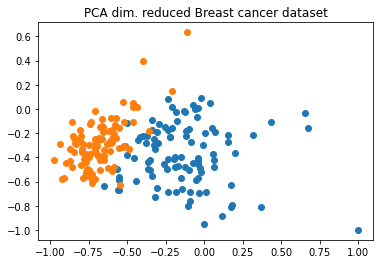

In [10]:
sample_Total, training_input, test_input, class_labels = breast_cancer(
    training_size=training_dataset_size, test_size=testing_dataset_size,
    n=feature_dim, plot_data=True  # ,gap=0.3 # for breast_cancer, delete gap parameter
)

In [11]:
training_input_pi_normalized = {k:(v+1)*np.pi for k,v in training_input.items()}
test_input_pi_normalized = {k:(v+1)*np.pi for k,v in test_input.items()} 

# Predict 50x50 mesh to visualize boundary
(train_for_pred, _), _ = split_dataset_to_data_and_labels(training_input_pi_normalized)
(test_for_pred, _), _ = split_dataset_to_data_and_labels(test_input_pi_normalized)


## Classical SVM

### Without Hyper Parameter Tuning


kernel matrix during the training:


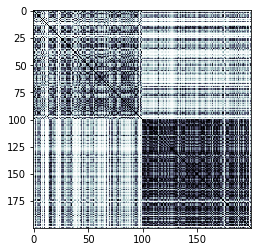

testing success ratio:  0.88
result:  ['A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'A']
truth :  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', '

In [12]:
result = SklearnSVM(training_input_pi_normalized, test_input_pi_normalized, mesh_list).run()
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r')
plt.show()

print("testing success ratio: ", result['testing_accuracy'])

# model evaluation
# To estimate mis-classification, use training/test data for prediction
(train_for_pred, _), _ = split_dataset_to_data_and_labels(training_input_pi_normalized)
(test_for_pred, _), _ = split_dataset_to_data_and_labels(test_input_pi_normalized)
train_result = SklearnSVM(training_input_pi_normalized, test_input_pi_normalized, train_for_pred).run()
test_result = SklearnSVM(training_input_pi_normalized, test_input_pi_normalized, test_for_pred).run()

eval_model(test_result["predicted_classes"])

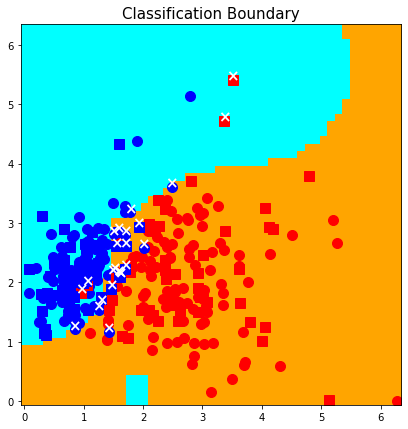

In [14]:
plt.figure(figsize=(7, 7))
heatmap(result["predicted_labels"])
scatter_data(train_for_pred, test_for_pred, train_result["predicted_labels"], test_result["predicted_labels"],yshift=-0.085)
plt.show()

# red and blue reprents label A and B respectively
# ● and ■ represents training and test dataset respectively

### With Hyper Parameter Tuning

In [33]:
space = {
    "sigma": hp.loguniform("sigma", np.log(0.001), np.log(10)),
    "lambda2": hp.loguniform("lambda2", np.log(0.001), np.log(10))
}

max_evals= 25
trials = Trials()
rstate = np.random.RandomState(seed)

history_g = []
# penalty is accounted for L1 norm regularization 
# fmin(functools.partial(score_rbf,train_in=training_input_unnormalized),
#      space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)
# penalty is accounted for L2 norm regularization 
fmin(functools.partial(score_rbf_l2,train_in=training_input_pi_normalized),
     space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

history_g = sorted(history_g, key=lambda tpl: tpl[1])
best = history_g[0]
print(f"best prames:{best[0]}, score:{best[1]:.4f}")

sigma: 0.1996383184555079, lambda2: 9.398534320413074
mean: 0.9199999999999999
sigma: 0.005400032833358021, lambda2: 2.5898673297026282
mean: 0.45999999999999996
sigma: 0.1327319518426118, lambda2: 0.03779007473269011
mean: 0.8999999999999999
sigma: 0.0024132593624641967, lambda2: 0.004659404373567989
mean: 0.45999999999999996
sigma: 7.586213275530738, lambda2: 1.8045234358169842
mean: 0.92
sigma: 3.782200332314479, lambda2: 0.010909938661357747
mean: 0.9349999999999999
sigma: 0.003267768475802967, lambda2: 0.20119892479196191
mean: 0.45999999999999996
sigma: 0.06739385409871532, lambda2: 0.9779963058616321
mean: 0.87
sigma: 0.01182500053080653, lambda2: 0.01827619995555661
mean: 0.48
sigma: 5.905333147487885, lambda2: 8.875535346220383
mean: 0.9249999999999999
sigma: 3.8519537426553017, lambda2: 0.014329745009361487
mean: 0.9299999999999999
sigma: 0.8610756135121739, lambda2: 0.023704478388749502
mean: 0.945
sigma: 1.2862042459675416, lambda2: 0.1364228217617679
mean: 0.955
sigma: 0.0

In [34]:
# evaluate test data with tunned hyper parameter
lambda2 = history_g[0][0]["lambda2"]
sigma = history_g[0][0]["sigma"]
gamma = 0.5/sigma**2

result_ker = SklearnSVM(training_input_pi_normalized, test_input_pi_normalized,None, gamma=gamma).run()

df_tr = make_df(training_input_pi_normalized)
data_tr = df_tr.iloc[:,:2].values
label_tr = df_tr["label"].astype(float)*(2)-1

df_test = make_df(test_input_pi_normalized)
data_test = df_test.iloc[:,:2].values

# create model
# penalty is accounted for L1 norm regularization 
# a, b = get_lagrange_param(t=label_tr, kernel=result_ker['kernel_matrix_training'],C=lambda2,print_mode=False)
# penalty is accounted for L2 norm regularization
[a, b, support] = optimize_svm(result_ker['kernel_matrix_training'], label_tr.values, scaling=None, lambda2=lambda2) 
# predict 
kernel_func = functools.partial(gaussian_kernel, sigma=sigma)
pred_score_train = array([model_rbf(row, a, label_tr, data_tr, b, kernel_func) for row in data_tr])
pred_score_test = array([model_rbf(row, a, label_tr, data_tr, b, kernel_func) for row in data_test])
pred_label_train = (pred_score_train > 0)*1
pred_label_test = (pred_score_test > 0)*1

df_test["pred_g"] = pred_score_test
# "Accucary", df_test.apply(lambda x: (x["label"] ==0 and x["pred_g"] < 0) or (x["label"] ==1 and x["pred_g"] > 0), axis=1).sum()/len(df_test)
eval_model(df_test["pred_g"].apply(lambda x: "A" if x < 0 else "B").tolist())

result:  ['A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B']
truth :  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 

In [17]:
df_test

,x,y,label,pred_g
0,2.815188,3.704715,0,-0.544657
1,1.473834,1.704919,0,0.246925
2,2.480601,1.806646,0,-0.957153
3,3.075148,1.668398,0,-1.058754
4,2.487562,1.610772,0,-0.956535
...,...,...,...,...
95,0.296016,1.522841,1,0.680363
96,0.377391,1.814826,1,0.850684
97,0.995178,1.984107,1,0.874469
98,0.671775,1.768647,1,0.904894


In [18]:
pred_score_mesh = array([model_rbf(array(row), a, label_tr, data_tr, b, kernel_func) for row in tqdm(mesh_list)])
pred_label_mesh = np.array([x>0 for x in pred_score_mesh])

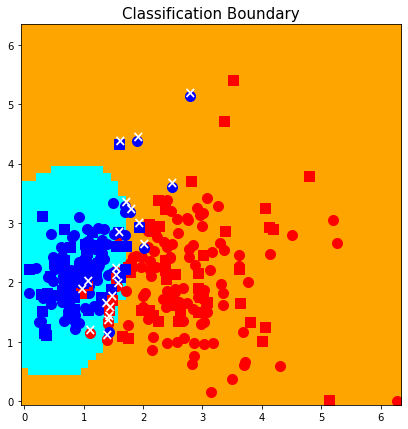

In [19]:
plt.figure(figsize=(7, 7))
heatmap(pred_label_mesh)
scatter_data(train_for_pred, test_for_pred, pred_label_train, pred_label_test ,yshift=-0.085)
plt.show()

# red and blue reprents label A and B respectively
# ● and ■ represents training and test dataset respectively

## Quantum SVM

### Without Hyper Parameter Tuning

kernel matrix during the training:


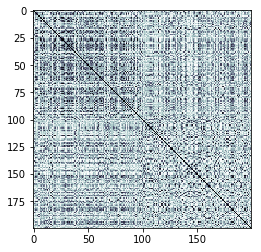

testing success ratio:  0.61
result:  ['B', 'B', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'A', 'B', 'A', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'A', 'B', 'A', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'B', 'A', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'B', 'B', 'A']
truth :  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', '

In [ ]:
%%time
# evaluation without hyper paramter
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
backend = BasicAer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(feature_dim, reps=2)
svm = QSVM(feature_map, training_input_pi_normalized, test_input_pi_normalized, None)  # the data for prediction can be fed later.
svm.random_seed = seed
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

print("testing success ratio: ", result['testing_accuracy'])

train_result = svm.predict(train_for_pred)
test_result = svm.predict(test_for_pred)

# model evaluation
eval_input = ["A" if x == 0 else "B" for x in test_result]
eval_model(eval_input)

In [ ]:
# this part takes around 30 mins in google colab. 
# speed depends the number of CPU since qiskit trigger multiprocess
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
(iter_num, input_size) = (51*3, 17)
mesh_list_iter = np.array(mesh_list).reshape(iter_num, input_size, feature_dim)

mesh_predict_tmp_br = []
for i, iter_list in enumerate(tqdm(mesh_list_iter)):
    tmp_list = svm.predict(iter_list)
    mesh_predict_tmp_br.append(tmp_list)
    print("epoch ", i, " has done ",list(tmp_list))

mesh_predict_result_bc = np.array(mesh_predict_tmp_br).reshape(-1)

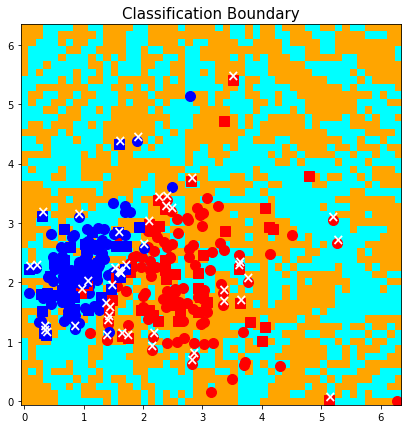

In [ ]:
plt.figure(figsize=(7, 7))
heatmap(mesh_predict_result_bc)
scatter_data(train_for_pred, test_for_pred, train_result, test_result ,yshift=-0.085)
plt.show()

# red and blue reprents label A and B respectively
# ● and ■ represents training and test dataset respectively

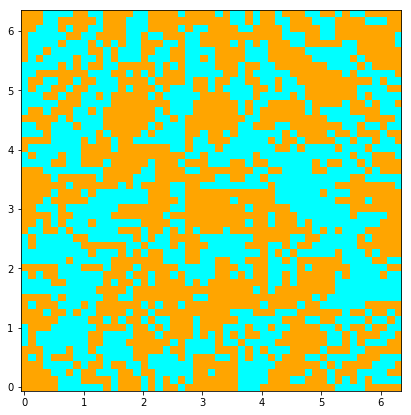

In [ ]:
plt.figure(figsize=(7, 7))
heatmap(mesh_predict_result_bc)

### With Hyper Parameter Tuning

In [ ]:
%%time 
# this process takes extremely long time
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
space = {
    "rep": hp.choice("rep", range(1,10)),
    "lambda2": hp.loguniform("lambda2", np.log(0.001), np.log(10))
}

max_evals= 25
trials = Trials()
rstate = np.random.RandomState(seed)
history_q = []
fmin(functools.partial(score_quantum,train_in=training_input_pi_normalized),
     space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

history_q = sorted(history_q, key=lambda tpl: tpl[1])
best = history_q[0]
print(f"best prames:{best[0]}, score:{best[1]:.4f}")


In [ ]:
history_q

[({'lambda2': 0.4951750794573975, 'rep': 1}, 0.16500000000000004),
 ({'lambda2': 0.4109546561543689, 'rep': 1}, 0.16999999999999993),
 ({'lambda2': 0.456637788201451, 'rep': 1}, 0.16999999999999993),
 ({'lambda2': 3.416951188980379, 'rep': 1}, 0.17999999999999994),
 ({'lambda2': 4.470537128310589, 'rep': 1}, 0.18500000000000005),
 ({'lambda2': 5.706840987057058, 'rep': 1}, 0.18999999999999995),
 ({'lambda2': 9.555135575112494, 'rep': 1}, 0.19999999999999996),
 ({'lambda2': 0.013595255614011417, 'rep': 1}, 0.20999999999999996),
 ({'lambda2': 0.9779963058616321, 'rep': 6}, 0.28500000000000003),
 ({'lambda2': 1.1842655043593648, 'rep': 6}, 0.28500000000000003),
 ({'lambda2': 3.0628801873477514, 'rep': 2}, 0.29000000000000004),
 ({'lambda2': 0.9744337603714344, 'rep': 5}, 0.29999999999999993),
 ({'lambda2': 0.5598353664679434, 'rep': 4}, 0.31499999999999995),
 ({'lambda2': 0.04223352475962893, 'rep': 7}, 0.32999999999999996),
 ({'lambda2': 0.007272965001694547, 'rep': 3}, 0.345),
 ({'lambd

kernel matrix during the training:


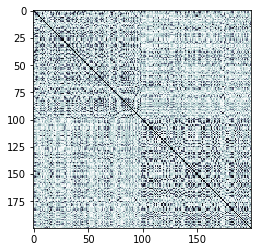

testing success ratio:  0.77
result:  ['B', 'A', 'A', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'A']
truth :  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', '

In [ ]:
%%time

# evaluate test data with tunned hyper parameter
lambda2 = history_q[0][0]["lambda2"]
rep = history_q[0][0]["rep"]
rep,lambda2

os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
backend = BasicAer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(feature_dim, reps=rep)
svm_opt = QSVM(feature_map, training_input_pi_normalized, test_input_pi_normalized, None, lambda2=lambda2)  # the data for prediction can be fed later.
svm_opt.random_seed = seed
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm_opt.run(quantum_instance)
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

print("testing success ratio: ", result['testing_accuracy'])

train_result = svm_opt.predict(train_for_pred)
test_result = svm_opt.predict(test_for_pred)

# model evaluation
eval_input = ["A" if x == 0 else "B" for x in test_result]
eval_model(eval_input)

In [ ]:
# this part takes around 30 mins in google colab. 
# speed depends the number of CPU since qiskit trigger multiprocess
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
(iter_num, input_size) = (51*3, 17)
mesh_list_iter = np.array(mesh_list).reshape(iter_num, input_size, feature_dim)

mesh_predict_tmp_opt_param = []
for i, iter_list in enumerate(tqdm(mesh_list_iter)):
    tmp_list = svm_opt.predict(iter_list)
    mesh_predict_tmp_opt_param.append(tmp_list)
    print("epoch ", i, " has done ",list(tmp_list))

mesh_predict_result_bc_opt = np.array(mesh_predict_tmp_opt_param).reshape(-1)

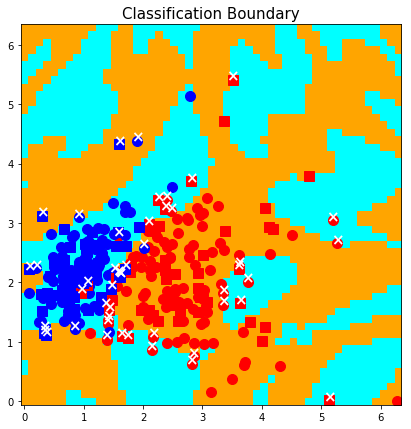

In [ ]:
plt.figure(figsize=(7, 7))
heatmap(mesh_predict_result_bc_opt)
scatter_data(train_for_pred, test_for_pred, train_result, test_result ,yshift=-0.085)
plt.show()

# red and blue reprents label A and B respectively
# ● and ■ represents training and test dataset respectively

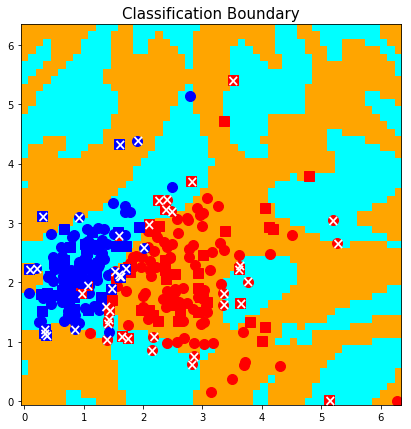

In [ ]:
# before hyper-parameter tuning
train_result_non_opt = svm.predict(train_for_pred)
test_result_non_opt = svm.predict(test_for_pred)
plt.figure(figsize=(7, 7))
heatmap(mesh_predict_result_bc)
scatter_data(train_for_pred, test_for_pred, train_result_non_opt, test_result_non_opt ,yshift=-0.085)
plt.show()

# red and blue reprents label A and B respectively
# ● and ■ represents training and test dataset respectively

# prepare dataset_ad_hoc_data

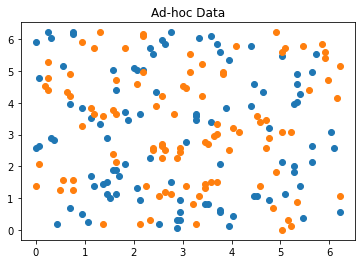

CPU times: user 6.92 s, sys: 6.18 ms, total: 6.93 s
Wall time: 6.96 s


In [20]:
%%time
# set gap zero
# training_dataset_size=100
# testing_dataset_size=50
aqua_globals.random_seed = seed
sample_Total, training_input_unnormalized, test_input_unnormalized, class_labels = ad_hoc_data(
    training_size=training_dataset_size, 
    test_size=testing_dataset_size, 
    n=feature_dim, gap=0, plot_data=True
)

In [21]:
(train_for_pred, _), _ = split_dataset_to_data_and_labels(training_input_unnormalized)
(test_for_pred, _), _ = split_dataset_to_data_and_labels(test_input_unnormalized)
dataset_array = np.vstack([train_for_pred, test_for_pred])
min_array, max_array = dataset_array.min(), dataset_array.max()

## Classical SVM

### Without Hyper Parameter Tuning

kernel matrix during the training:


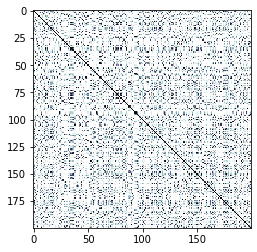

testing success ratio:  0.67


In [22]:
result = SklearnSVM(training_input_unnormalized, test_input_unnormalized, mesh_list).run()
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r')
plt.show()

print("testing success ratio: ", result['testing_accuracy'])

In [24]:
# model evaluation

# model evaluation
# To estimate mis-classification, use training/test data for prediction
(train_for_pred, _), _ = split_dataset_to_data_and_labels(training_input_unnormalized)
(test_for_pred, _), _ = split_dataset_to_data_and_labels(test_input_unnormalized)
train_result = SklearnSVM(training_input_unnormalized, test_input_unnormalized, train_for_pred).run()
test_result = SklearnSVM(training_input_unnormalized, test_input_unnormalized, test_for_pred).run()

eval_model(test_result["predicted_classes"])

result:  ['B', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'B', 'B', 'A', 'A', 'A', 'B', 'A', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'B']
truth :  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 

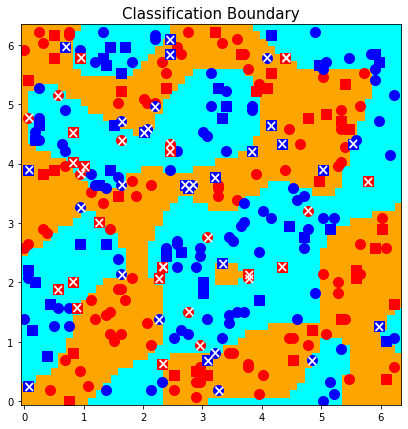

In [26]:
plt.figure(figsize=(7, 7))               
heatmap(result["predicted_labels"])
scatter_data(train_for_pred, test_for_pred, train_result["predicted_labels"], test_result["predicted_labels"],yshift=-0.085)
plt.show()

# red and blue reprents label A and B respectively
# ● and ■ represents training and test dataset respectively

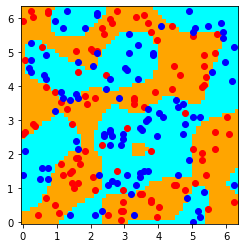

In [27]:

heatmap(result["predicted_labels"])
plot_train_A = training_input_unnormalized["A"]
plot_train_B = training_input_unnormalized["B"]
plt.scatter(plot_train_A[:,0],plot_train_A[:,1],c="red")
plt.scatter(plot_train_B[:,0],plot_train_B[:,1],c="blue")

### With Hyper Parameter Tuning

In [35]:
space = {
    "sigma": hp.loguniform("sigma", np.log(0.001), np.log(10)),
    "lambda2": hp.loguniform("lambda2", np.log(0.001), np.log(10))
}

max_evals= 25
trials = Trials()
rstate = np.random.RandomState(seed)

history_g = []
# penalty is accounted for L1 norm regularization 
# fmin(functools.partial(score_rbf,train_in=training_input_unnormalized),
#      space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)
# penalty is accounted for L2 norm regularization 
fmin(functools.partial(score_rbf_l2,train_in=training_input_unnormalized),
     space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

history_g = sorted(history_g, key=lambda tpl: tpl[1])
best = history_g[0]
print(f"best prames:{best[0]}, score:{best[1]:.4f}")

sigma: 0.1996383184555079, lambda2: 9.398534320413074
mean: 0.675
sigma: 0.005400032833358021, lambda2: 2.5898673297026282
mean: 0.45999999999999996
sigma: 0.1327319518426118, lambda2: 0.03779007473269011
mean: 0.63
sigma: 0.0024132593624641967, lambda2: 0.004659404373567989
mean: 0.45999999999999996
sigma: 7.586213275530738, lambda2: 1.8045234358169842
mean: 0.51
sigma: 3.782200332314479, lambda2: 0.010909938661357747
mean: 0.55
sigma: 0.003267768475802967, lambda2: 0.20119892479196191
mean: 0.45999999999999996
sigma: 0.06739385409871532, lambda2: 0.9779963058616321
mean: 0.58
sigma: 0.01182500053080653, lambda2: 0.01827619995555661
mean: 0.475
sigma: 5.905333147487885, lambda2: 8.875535346220383
mean: 0.515
sigma: 3.8519537426553017, lambda2: 0.014329745009361487
mean: 0.55
sigma: 0.8610756135121739, lambda2: 0.023704478388749502
mean: 0.6950000000000001
sigma: 1.2862042459675416, lambda2: 0.1364228217617679
mean: 0.64
sigma: 0.006889005706147214, lambda2: 0.003521102234264457
mean: 

In [36]:
# evaluate test data with tunned hyper parameter
lambda2 = history_g[0][0]["lambda2"]
sigma = history_g[0][0]["sigma"]
gamma = 0.5/sigma**2

result_ker = SklearnSVM(training_input_unnormalized, test_input_unnormalized,None, gamma=gamma).run()

df_tr = make_df(training_input_unnormalized)
data_tr = df_tr.iloc[:,:2].values
label_tr = df_tr["label"].astype(float)*(2)-1

df_test = make_df(test_input_unnormalized)
data_test = df_test.iloc[:,:2].values

# create model
# penalty is accounted for L1 norm regularization 
# a, b = get_lagrange_param(t=label_tr, kernel=result_ker['kernel_matrix_training'],C=lambda2,print_mode=False)
# penalty is accounted for L2 norm regularization
[a, b, support] = optimize_svm(result_ker['kernel_matrix_training'], label_tr.values, scaling=None, lambda2=lambda2) 
# predict 
kernel_func = functools.partial(gaussian_kernel, sigma=sigma)
pred_score_train = array([model_rbf(row, a, label_tr, data_tr, b, kernel_func) for row in data_tr])
pred_score_test = array([model_rbf(row, a, label_tr, data_tr, b, kernel_func) for row in data_test])
pred_label_train = (pred_score_train > 0)*1
pred_label_test = (pred_score_test > 0)*1

df_test["pred_g"] = pred_score_test
# "Accucary", df_test.apply(lambda x: (x["label"] ==0 and x["pred_g"] < 0) or (x["label"] ==1 and x["pred_g"] > 0), axis=1).sum()/len(df_test)
eval_model(df_test["pred_g"].apply(lambda x: "A" if x < 0 else "B").tolist())

result:  ['A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'B', 'A', 'B', 'A', 'A', 'B', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'B']
truth :  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 

In [37]:
pred_score_mesh = array([model_rbf(array(row), a, label_tr, data_tr, b, kernel_func) for row in tqdm(mesh_list)])
pred_label_mesh = np.array([x>0 for x in pred_score_mesh])

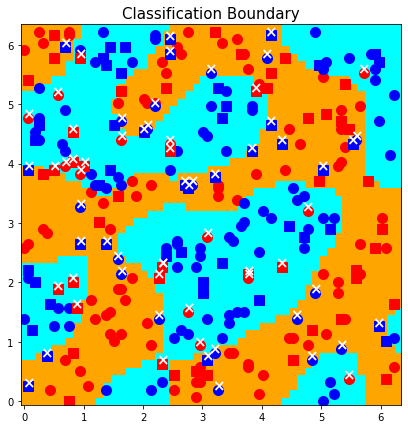

In [38]:
plt.figure(figsize=(7, 7))
heatmap(pred_label_mesh)
scatter_data(train_for_pred, test_for_pred, pred_label_train, pred_label_test ,yshift=-0.085)
plt.show()

# red and blue reprents label A and B respectively
# ● and ■ represents training and test dataset respectively

## Quantum SVM

### Without Hyper Parameter Tuning

In [ ]:
%%time
backend = BasicAer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(feature_dim, reps=2)
svm = QSVM(feature_map, training_input_unnormalized, test_input_normalized, None)# the data for prediction can be fed later.
svm.random_seed = seed
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)



CPU times: user 1min 47s, sys: 1.48 s, total: 1min 49s
Wall time: 3min 14s


kernel matrix during the training:


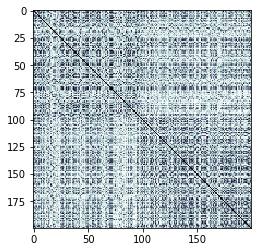

testing success ratio:  0.9


In [ ]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(abs(kernel_matrix)),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

print("testing success ratio: ", result['testing_accuracy'])

In [ ]:
%%time
train_result = svm.predict(train_for_pred)
test_result = svm.predict(test_for_pred)

# model evaluation
eval_input = ["A" if x == 0 else "B" for x in test_result]
eval_model(eval_input)

result:  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
truth :  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 

In [ ]:
# # this part takes around 30 mins in google colab. 
# speed depends the number of CPU since qiskit trigger multiprocess
(iter_num, input_size) = (51*3, 17)
mesh_list_iter = np.array(mesh_list).reshape(iter_num, input_size, feature_dim)

mesh_predict_tmp = []
for i, iter_list in enumerate(tqdm(mesh_list_iter)):
    tmp_list = svm.predict(iter_list)
    mesh_predict_tmp.append(tmp_list)
    print("epoch ", i, " has done ",list(tmp_list))

# print(mesh_predict_tmp)
mesh_predict_result_ad = np.array(mesh_predict_tmp).reshape(-1)

epoch  0  has done  [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]
epoch  1  has done  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
epoch  2  has done  [1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]
epoch  3  has done  [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]
epoch  4  has done  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]
epoch  5  has done  [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
epoch  6  has done  [1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
epoch  7  has done  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]
epoch  8  has done  [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
epoch  9  has done  [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
epoch  10  has done  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1]
epoch  11  has done  [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]
epoch  12  has done  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]
epoch  13  has done  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

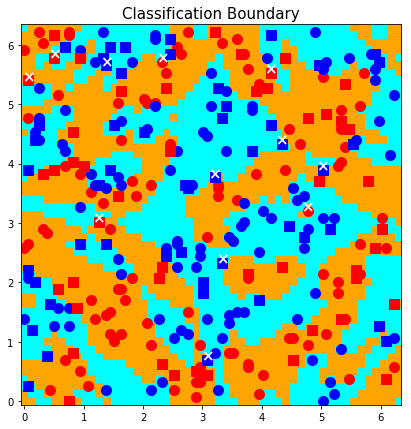

In [ ]:
plt.figure(figsize=(7, 7))               
heatmap(mesh_predict_result_ad)
scatter_data(train_for_pred, test_for_pred, train_result, test_result ,yshift=-0.085)
plt.show()

# red and blue reprents label A and B respectively
# ● and ■ represents training and test dataset respectively

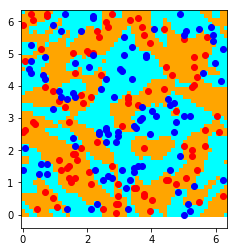

In [ ]:

heatmap(mesh_predict_result_ad)
plot_train_A = training_input_unnormalized["A"]
plot_train_B = training_input_unnormalized["B"]
plt.scatter(plot_train_A[:,0],plot_train_A[:,1],c="red")
plt.scatter(plot_train_B[:,0],plot_train_B[:,1],c="blue")

kernel matrix during the training:


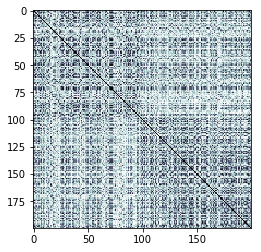

testing success ratio:  0.9
result:  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
truth :  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B

In [ ]:
%%time

# evaluate test data with tunned hyper parameter
lambda2 = history_q[0][0]["lambda2"]
rep = history_q[0][0]["rep"]
rep,lambda2

os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
backend = BasicAer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(feature_dim, reps=2)
svm_opt = QSVM(feature_map, training_input_unnormalized, test_input_unnormalized, None)  # the data for prediction can be fed later.
svm_opt.random_seed = seed
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm_opt.run(quantum_instance)
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

print("testing success ratio: ", result['testing_accuracy'])

train_result = svm_opt.predict(train_for_pred)
test_result = svm_opt.predict(test_for_pred)

# model evaluation
eval_input = ["A" if x == 0 else "B" for x in test_result]
eval_model(eval_input)


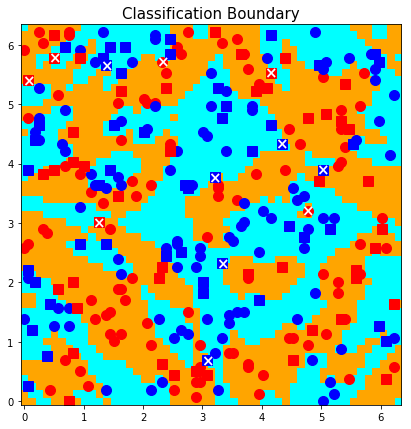

In [ ]:
plt.figure(figsize=(7, 7))               
heatmap(mesh_predict_result_ad)
scatter_data(train_for_pred, test_for_pred, train_result, test_result ,yshift=-0.085)
plt.show()

# red and blue reprents label A and B respectively
# ● and ■ represents training and test dataset respectively

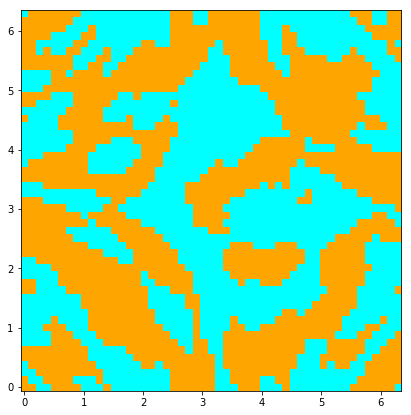

In [ ]:
plt.figure(figsize=(7, 7))               
heatmap(mesh_predict_result_ad)

### With Hyper Parameter Tuning

In [ ]:
%%time 
# this process takes extremely long time
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
space = {
    "rep": hp.choice("rep", range(1,10)),
    "lambda2": hp.loguniform("lambda2", np.log(0.001), np.log(10))
}

max_evals= 25
trials = Trials()
rstate = np.random.RandomState(seed)
history_q = []
fmin(functools.partial(score_quantum,train_in=training_input_unnormalized),
     space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

history_q = sorted(history_q, key=lambda tpl: tpl[1])
best = history_q[0]
print(f"best prames:{best[0]}, score:{best[1]:.4f}")


In [ ]:
history_q

[({'lambda2': 0.018002718351046443, 'rep': 2}, 0.03500000000000003),
 ({'lambda2': 0.02894242088720116, 'rep': 2}, 0.03500000000000003),
 ({'lambda2': 0.03334055173970387, 'rep': 2}, 0.03500000000000003),
 ({'lambda2': 0.08351409258775638, 'rep': 2}, 0.040000000000000036),
 ({'lambda2': 0.0011871698109490226, 'rep': 2}, 0.06500000000000006),
 ({'lambda2': 3.0628801873477514, 'rep': 2}, 0.09499999999999997),
 ({'lambda2': 0.013595255614011417, 'rep': 1}, 0.22499999999999998),
 ({'lambda2': 0.4109546561543689, 'rep': 1}, 0.24),
 ({'lambda2': 3.416951188980379, 'rep': 1}, 0.2650000000000001),
 ({'lambda2': 4.470537128310589, 'rep': 1}, 0.2650000000000001),
 ({'lambda2': 0.04297649232546777, 'rep': 4}, 0.36),
 ({'lambda2': 0.3379856787135712, 'rep': 9}, 0.37),
 ({'lambda2': 0.18345409505505353, 'rep': 9}, 0.375),
 ({'lambda2': 0.9779963058616321, 'rep': 6}, 0.39),
 ({'lambda2': 1.1842655043593648, 'rep': 6}, 0.39),
 ({'lambda2': 0.22068563028667662, 'rep': 8}, 0.39),
 ({'lambda2': 0.042233

kernel matrix during the training:


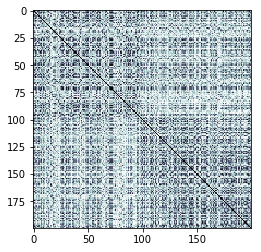

testing success ratio:  0.93
result:  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
truth :  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', '

In [ ]:
%%time

# evaluate test data with tunned hyper parameter
lambda2 = history_q[0][0]["lambda2"]
rep = history_q[0][0]["rep"]
rep,lambda2

# Wall time: 9.47 s for train_size = 20 test_size = 10
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
backend = BasicAer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(feature_dim, reps=rep)
svm_opt = QSVM(feature_map, training_input_unnormalized, test_input_unnormalized, None, lambda2=lambda2)  # the data for prediction can be fed later.
svm_opt.random_seed = seed
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm_opt.run(quantum_instance)
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

print("testing success ratio: ", result['testing_accuracy'])

train_result = svm_opt.predict(train_for_pred)
test_result = svm_opt.predict(test_for_pred)

# モデル評価
eval_input = ["A" if x == 0 else "B" for x in test_result]
eval_model(eval_input)

In [ ]:
# this part takes around 30 mins in google colab. 
# speed depends the number of CPU since qiskit trigger multiprocess
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
(iter_num, input_size) = (51*3, 17)
mesh_list_iter = np.array(mesh_list).reshape(iter_num, input_size, feature_dim)

mesh_predict_tmp_opt_param = []
for i, iter_list in enumerate(tqdm(mesh_list_iter)):
    tmp_list = svm_opt.predict(iter_list)
    mesh_predict_tmp_opt_param.append(tmp_list)
    print("epoch ", i, " has done ",list(tmp_list))

mesh_predict_result_ad_opt = np.array(mesh_predict_tmp_opt_param).reshape(-1)

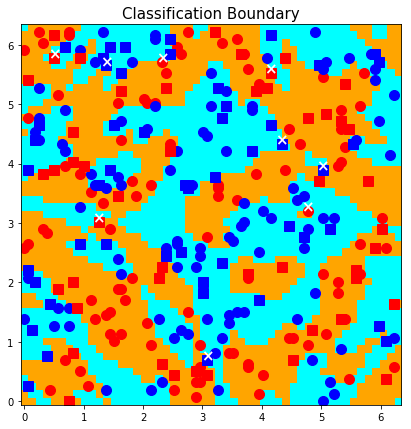

In [ ]:

plt.figure(figsize=(7, 7))
heatmap(mesh_predict_result_ad_opt)
scatter_data(train_for_pred, test_for_pred, train_result, test_result ,yshift=-0.085)
plt.show()

# red and blue reprents label A and B respectively
# ● and ■ represents training and test dataset respectively

# showing that kernel is not periodic for π

In [ ]:
%%time

# if data is shifted by 2π, model performance decays significantly

training_dataset_size=10
testing_dataset_size=5
aqua_globals.random_seed = seed
sample_Total, training_input_unnormalized, test_input_unnormalized, class_labels = ad_hoc_data(
    training_size=training_dataset_size, 
    test_size=testing_dataset_size, 
    n=feature_dim, gap=0.3, plot_data=True
)

(train_for_pred, _), _ = split_dataset_to_data_and_labels(training_input_unnormalized)
(test_for_pred, _), _ = split_dataset_to_data_and_labels(test_input_unnormalized)
dataset_array = np.vstack([train_for_pred, test_for_pred])
min_array, max_array = dataset_array.min(), dataset_array.max()
training_input_normalized = {k:v-np.pi*2 for k,v in training_input_unnormalized.items()}
test_input_normalized = {k:v-np.pi*2 for k,v in test_input_unnormalized.items()} 
# training_input_normalized = {k:v for k,v in training_input_unnormalized.items()}
# test_input_normalized = {k:v for k,v in test_input_unnormalized.items()} 


backend = BasicAer.get_backend('qasm_simulator')
feature_map = ZZFeatureMap(feature_dim, reps=2)
svm = QSVM(feature_map, training_input_normalized, test_input_normalized, None)# the data for prediction can be fed later.
svm.random_seed = seed
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)

train_result = svm.predict(train_for_pred)
test_result = svm.predict(test_for_pred)

# model evaluation
eval_input = ["A" if x == 0 else "B" for x in test_result]
eval_model(eval_input)